In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(texts_list):
    with torch.no_grad():
        label_ids = []
        text_features_cuda = []
        cls_features_cuda = []
        for label_id, texts in texts_list.items():
            label_ids.append([label_id] * len(texts))
            class_embeddings = model.encode_text(clip.tokenize(texts).to(device))
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            text_features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        text_features = torch.vstack(text_features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, text_features, text_features_cuda, cls_features_cuda, masked_similarity

In [10]:
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create template text features
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(template_label_texts_list)

In [11]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/airplane_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [12]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
}

In [13]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 1 prompts for (40)Beechcraft 1900
['-A twin-engine turboprop airplane that seats up to 19 passengers\n-Has a cruising speed ofine 300 mph (483 km/h)\n-A typical range is 1,350 miles (2,174 km)\n.']

Filtered 2 prompts for (89)Metroliner
['TheMetrolineris a 19-seat, twin-turboprop business class airliner manufactured by Fairchild Aircraft.', 'TheMetroliner is a turboprop-powered regional airliner that was introducted in 1967.']

Filtered 1 prompts for (86)MD-80
['.']

Filtered 1 prompts for (7)737-700
['Aircraft description from AirFleets.']

Filtered 1 prompts for (79)Global Express
['.']

Filtered 1 prompts for (43)C-47
['The aircraft has a low-mounted cantilever wing and a tricycle landing gear.']

Filtered 1 prompts for (63)Dornier 328
['The DO328 aircraft is a high-wing, twin-engine, turboprop-powered plane.']

Filtered 1 prompts for (21)A300B4
['It is a twin-engine, wide-body aircraft that can carry up to 250 passengers.']

Filtered 1 prompts for (35)ATR-72
['.']

Filtere

In [14]:
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
# Create original gpt3 text features
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(filtered_gpt3_label_texts_list)

In [15]:
from collections import defaultdict

imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)

In [16]:
# Create image features
with torch.no_grad():
    img_label_ids = []
    img_features_cuda = []
    img_cls_features_cuda = []
    img_cls_name_similarity_cuda = []
    img_template_cls_similarity_cuda = []
    img_template_text_similarity_cuda = []
    img_original_gpt3_cls_similarity_cuda = []
    img_original_gpt3_text_similarity_cuda = []
    img_filtered_gpt3_cls_similarity_cuda = []
    img_filtered_gpt3_text_similarity_cuda = []
    for label_id, imgs in tqdm(imgs_grouped.items()):
        img_label_ids.append([label_id] * len(imgs))
        imgs = torch.stack([preprocess(img) for img in imgs]).to(device)
        img_embeddings = model.encode_image(imgs)
        img_embeddings /= img_embeddings.norm(dim=-1, keepdim=True)
        img_embedding = img_embeddings.mean(dim=0)
        img_embedding /= img_embedding.norm()
        img_features_cuda.append(img_embeddings)
        img_cls_features_cuda.append(img_embedding)
        # mean by cls then mul
        img_cls_name_similarity_cuda.append((img_embeddings @ cls_name_features_cuda.T).mean(dim=0))
        img_template_cls_similarity_cuda.append((img_embeddings @ template_cls_features_cuda.T).mean(dim=0))
        img_original_gpt3_cls_similarity_cuda.append((img_embeddings @ original_gpt3_cls_features_cuda.T).mean(dim=0))
        img_filtered_gpt3_cls_similarity_cuda.append((img_embeddings @ filtered_gpt3_cls_features_cuda.T).mean(dim=0))
        # mul then mean by cls
        img_template_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in template_text_features_cuda]))
        img_original_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in original_gpt3_text_features_cuda]))
        img_filtered_gpt3_text_similarity_cuda.append(torch.Tensor([(img_embeddings @ text_features_cuda.T).mean() for text_features_cuda in filtered_gpt3_text_features_cuda]))
    img_label_ids = np.hstack(img_label_ids)
    img_features_cuda = torch.vstack(img_features_cuda)
    img_features = img_features_cuda.cpu().numpy()
    img_cls_features_cuda = torch.vstack(img_cls_features_cuda)
    # mean by cls then mul
    img_cls_name_similarity = torch.vstack(img_cls_name_similarity_cuda).cpu().numpy()
    img_template_cls_similarity = torch.vstack(img_template_cls_similarity_cuda).cpu().numpy()
    img_original_gpt3_cls_similarity = torch.vstack(img_original_gpt3_cls_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_cls_similarity = torch.vstack(img_filtered_gpt3_cls_similarity_cuda).cpu().numpy()
    # mul then mean by cls
    img_template_text_similarity = torch.vstack(img_template_text_similarity_cuda).cpu().numpy()
    img_original_gpt3_text_similarity = torch.vstack(img_original_gpt3_text_similarity_cuda).cpu().numpy()
    img_filtered_gpt3_text_similarity = torch.vstack(img_filtered_gpt3_text_similarity_cuda).cpu().numpy()

    # Fill diagonal for better visibility
    img_masked_similarity = (img_cls_features_cuda @ img_cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


In [17]:
# Zero-shot classification using CLIP
with torch.no_grad():
    logits_cls_name_cuda = img_features_cuda @ cls_name_features_cuda.T
    logits_template_cls_cuda = img_features_cuda @ template_cls_features_cuda.T
    logits_original_gpt3_cls_cuda = img_features_cuda @ original_gpt3_cls_features_cuda.T
    logits_filtered_gpt3_cls_cuda = img_features_cuda @ filtered_gpt3_cls_features_cuda.T

    pred_cls_name = logits_cls_name_cuda.argmax(dim=-1).cpu().numpy()
    pred_template_cls = logits_template_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_original_gpt3_cls = logits_original_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()
    pred_filtered_gpt3_cls = logits_filtered_gpt3_cls_cuda.argmax(dim=-1).cpu().numpy()

    correct_cls_name = (pred_cls_name == img_label_ids).mean()
    correct_template_cls = (pred_template_cls == img_label_ids).mean()
    correct_original_gpt3 = (pred_original_gpt3_cls == img_label_ids).mean()
    correct_filtered_gpt3 = (pred_filtered_gpt3_cls == img_label_ids).mean()

In [18]:
print(f'Accuracy of CLIP with class names: {correct_cls_name*100:.2f}%')
print(f'Accuracy of CLIP with text template: {correct_template_cls*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text: {correct_original_gpt3*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text: {correct_filtered_gpt3*100:.2f}%')

Accuracy of CLIP with class names: 21.00%
Accuracy of CLIP with text template: 23.88%
Accuracy of CLIP with original GPT-3 text: 27.84%
Accuracy of CLIP with filtered GPT-3 text: 28.77%


In [19]:
def print_top_similarity(similarity, top=10):
    # Get the indices of top similarity values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top similarities
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, Similarity: {similarity[label1, label2]}')

In [20]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [21]:
def visualize_auto_similarity(masked_similarity, title):
    print(f'{title.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_similarity(np.triu(masked_similarity, k=1))
    plot_similarity(masked_similarity, title)

In [22]:
def visualize_cross_similarity(similarity, title, xlabel='Text', ylabel='Image'):
    print(f'{title.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_similarity(similarity, top=20)
    plot_similarity(similarity, title, xlabel=xlabel, ylabel=ylabel)

Class name similarity mean: 0.73974609375
Class name similarity std: 0.09033203125
Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.9990234375
Rank 2: (6)737-600 - (7)737-700, Similarity: 0.99560546875
Rank 3: (4)737-400 - (6)737-600, Similarity: 0.9951171875
Rank 4: (5)737-500 - (6)737-600, Similarity: 0.99462890625
Rank 5: (6)737-600 - (8)737-800, Similarity: 0.99462890625
Rank 6: (7)737-700 - (8)737-800, Similarity: 0.994140625
Rank 7: (5)737-500 - (9)737-900, Similarity: 0.994140625
Rank 8: (4)737-400 - (5)737-500, Similarity: 0.994140625
Rank 9: (27)A330-200 - (28)A330-300, Similarity: 0.99365234375
Rank 10: (3)737-300 - (5)737-500, Similarity: 0.99365234375


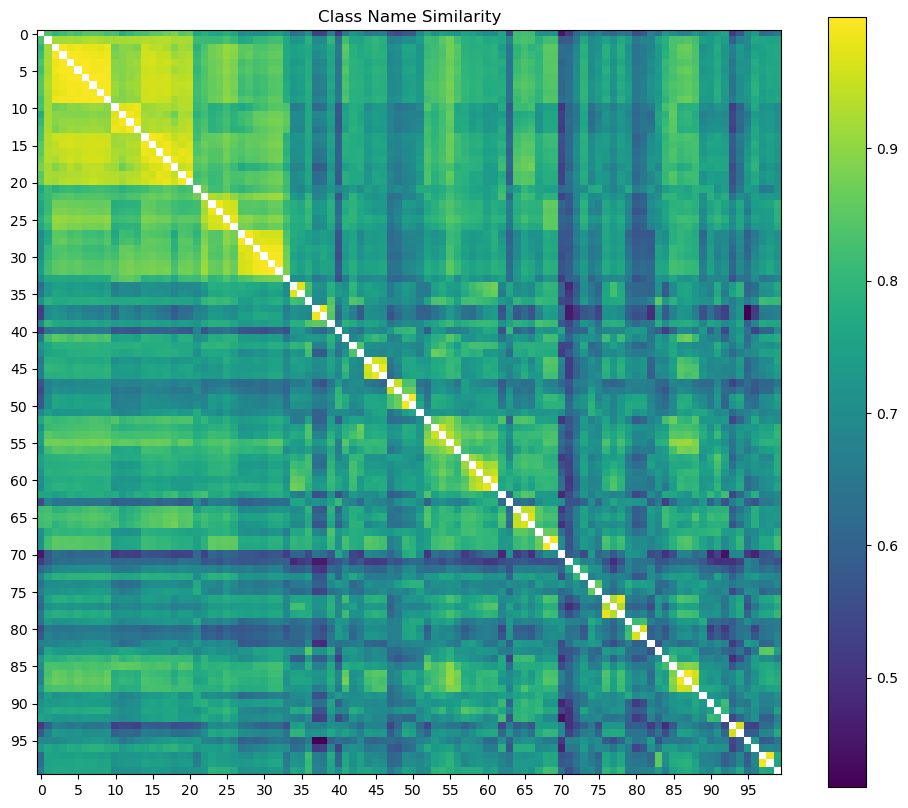

Text template similarity mean: 0.771484375
Text template similarity std: 0.07659912109375
Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, Similarity: 0.998046875
Rank 3: (6)737-600 - (7)737-700, Similarity: 0.99755859375
Rank 4: (19)777-200 - (20)777-300, Similarity: 0.99755859375
Rank 5: (8)737-800 - (9)737-900, Similarity: 0.99755859375
Rank 6: (7)737-700 - (9)737-900, Similarity: 0.9970703125
Rank 7: (6)737-600 - (8)737-800, Similarity: 0.9970703125
Rank 8: (16)767-200 - (17)767-300, Similarity: 0.9970703125
Rank 9: (6)737-600 - (9)737-900, Similarity: 0.9970703125
Rank 10: (27)A330-200 - (28)A330-300, Similarity: 0.9970703125


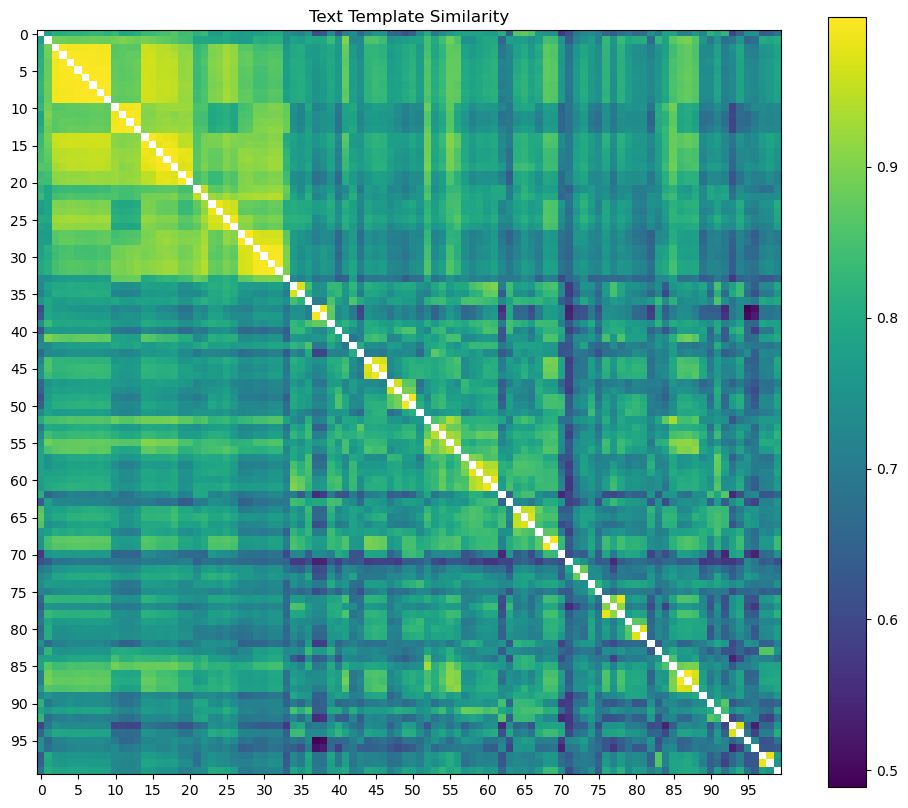

Original gpt-3 text similarity mean: 0.775390625
Original gpt-3 text similarity std: 0.0770263671875
Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.99853515625
Rank 2: (6)737-600 - (9)737-900, Similarity: 0.998046875
Rank 3: (5)737-500 - (6)737-600, Similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, Similarity: 0.998046875
Rank 5: (17)767-300 - (18)767-400, Similarity: 0.998046875
Rank 6: (30)A340-300 - (32)A340-600, Similarity: 0.99755859375
Rank 7: (30)A340-300 - (31)A340-500, Similarity: 0.9970703125
Rank 8: (29)A340-200 - (30)A340-300, Similarity: 0.9970703125
Rank 9: (5)737-500 - (9)737-900, Similarity: 0.9970703125
Rank 10: (6)737-600 - (7)737-700, Similarity: 0.99658203125


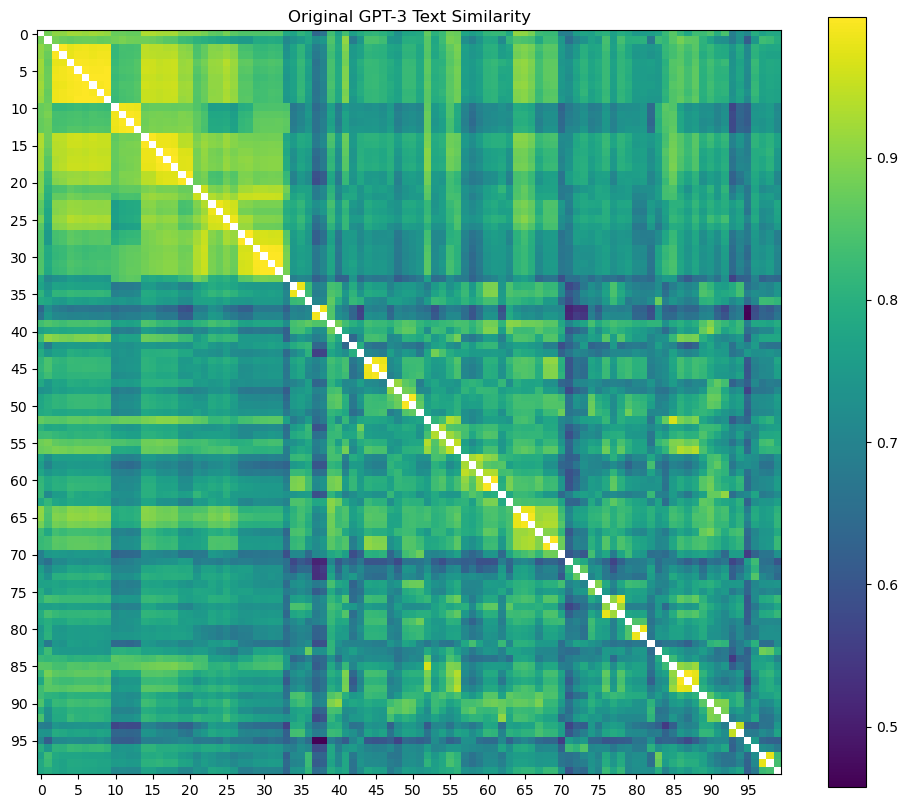

Filtered gpt-3 text similarity mean: 0.7705078125
Filtered gpt-3 text similarity std: 0.0784912109375
Rank 1: (5)737-500 - (6)737-600, Similarity: 0.99853515625
Rank 2: (31)A340-500 - (32)A340-600, Similarity: 0.99853515625
Rank 3: (6)737-600 - (9)737-900, Similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, Similarity: 0.998046875
Rank 5: (5)737-500 - (9)737-900, Similarity: 0.99755859375
Rank 6: (17)767-300 - (18)767-400, Similarity: 0.99755859375
Rank 7: (30)A340-300 - (32)A340-600, Similarity: 0.99755859375
Rank 8: (4)737-400 - (5)737-500, Similarity: 0.99755859375
Rank 9: (6)737-600 - (8)737-800, Similarity: 0.99755859375
Rank 10: (7)737-700 - (9)737-900, Similarity: 0.99755859375


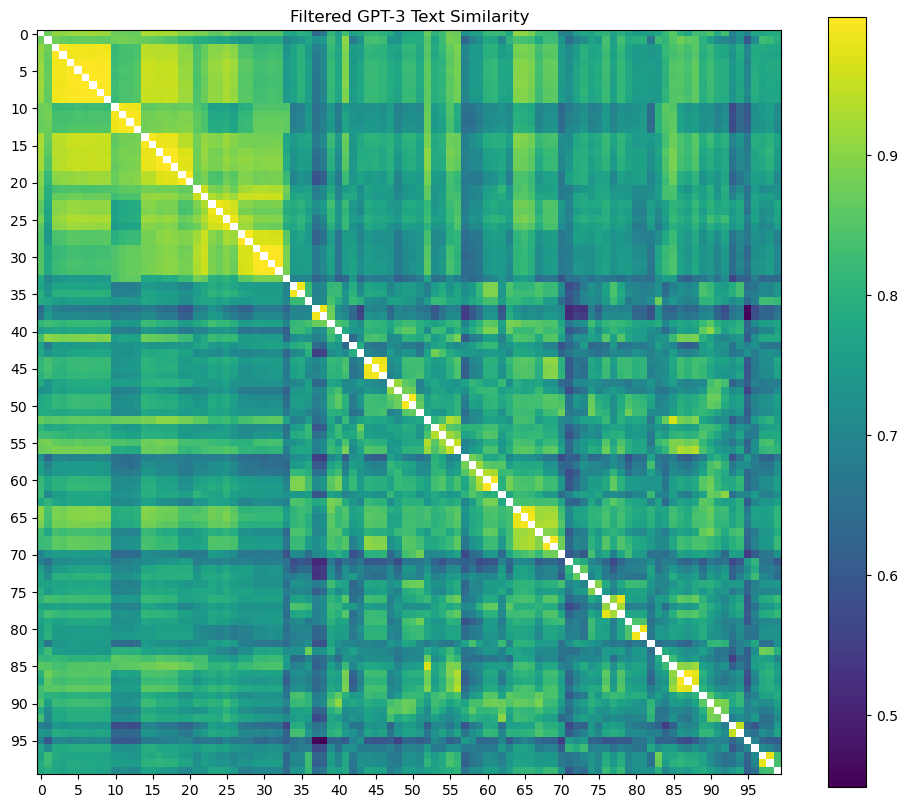

In [23]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name Similarity')
visualize_auto_similarity(template_masked_similarity, 'Text Template Similarity')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text Similarity')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text Similarity')

Image similarity mean: 0.8623046875
Image similarity std: 0.07965087890625
Rank 1: (80)Gulfstream IV - (81)Gulfstream V, Similarity: 0.99755859375
Rank 2: (49)Cessna 525 - (50)Cessna 560, Similarity: 0.99365234375
Rank 3: (70)Embraer Legacy 600 - (79)Global Express, Similarity: 0.99365234375
Rank 4: (3)737-300 - (5)737-500, Similarity: 0.99267578125
Rank 5: (39)BAE-125 - (50)Cessna 560, Similarity: 0.9921875
Rank 6: (3)737-300 - (4)737-400, Similarity: 0.99169921875
Rank 7: (37)BAE 146-200 - (38)BAE 146-300, Similarity: 0.99169921875
Rank 8: (51)Challenger 600 - (70)Embraer Legacy 600, Similarity: 0.99169921875
Rank 9: (3)737-300 - (8)737-800, Similarity: 0.9912109375
Rank 10: (34)ATR-42 - (35)ATR-72, Similarity: 0.9912109375


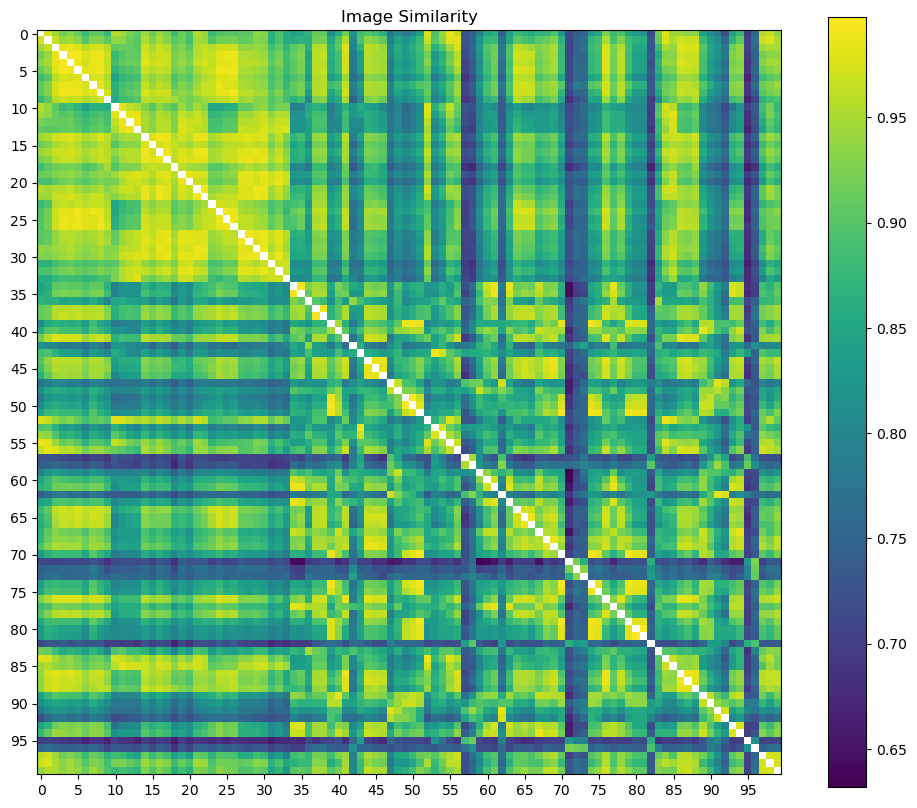

Image to class name similarity mean: 0.2379150390625
Image to class name similarity std: 0.035247802734375
Image to class name similarity diagonal mean: 0.295166015625
Image to class name similarity diagonal std: 0.0189666748046875
Image to class name similarity non-diagonal mean: 0.2374267578125
Image to class name similarity non-diagonal std: 0.034912109375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.2431640625
Rank 1: (81)Gulfstream V - (81)Gulfstream V, Similarity: 0.32666015625
Rank 2: (83)Il-76 - (39)BAE-125, Similarity: 0.326171875
Rank 3: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.323974609375
Rank 4: (74)Falcon 2000 - (74)Falcon 2000, Similarity: 0.32373046875
Rank 5: (80)Gulfstream IV - (81)Gulfstream V, Similarity: 0.32275390625
Rank 6: (47)Cessna 172 - (47)Cessna 172, Similarity: 0.322509765625
Rank 7: (72)F-16A/B - (72)F-16A/B, Similarity: 0.322509765625
Rank 8: (81)Gulfstream V - (80)Gulfstream IV, Similarity: 0.3220214

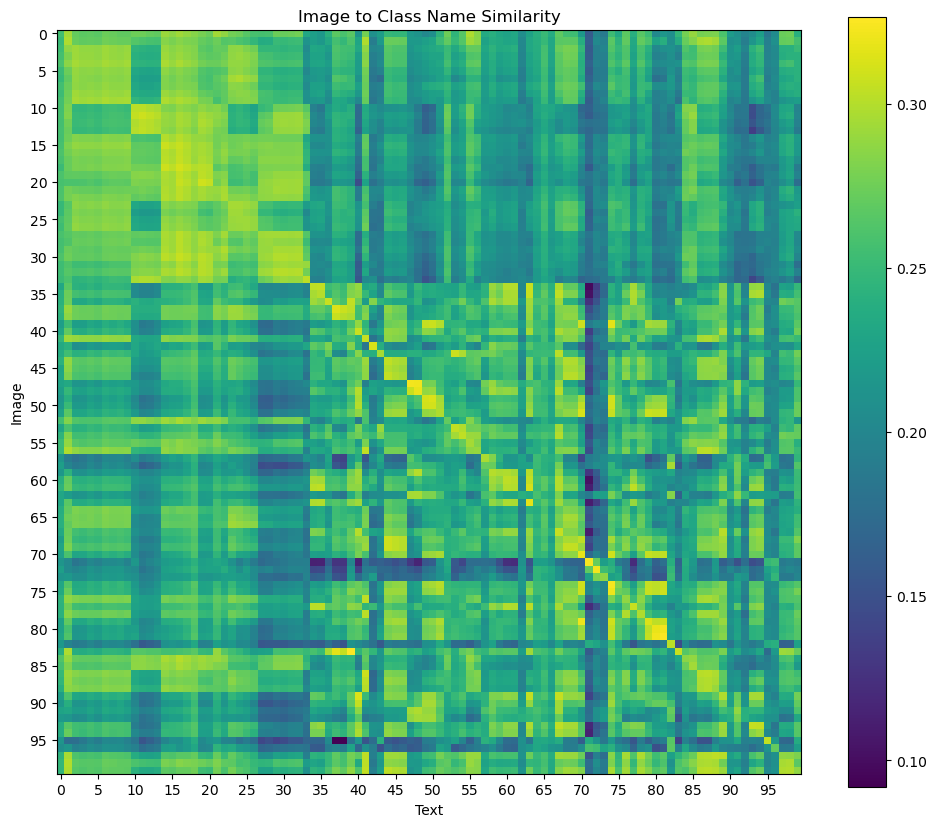

Image to text template similarity mean: 0.2509765625
Image to text template similarity std: 0.0386962890625
Image to text template similarity diagonal mean: 0.315185546875
Image to text template similarity diagonal std: 0.0178070068359375
Image to text template similarity non-diagonal mean: 0.250244140625
Image to text template similarity non-diagonal std: 0.038299560546875
Image to text template similarity diagonal mean to non-diagonal mean ratio: 1.259765625
Rank 1: (83)Il-76 - (39)BAE-125, Similarity: 0.344482421875
Rank 2: (81)Gulfstream V - (81)Gulfstream V, Similarity: 0.343017578125
Rank 3: (81)Gulfstream V - (80)Gulfstream IV, Similarity: 0.341796875
Rank 4: (37)BAE 146-200 - (37)BAE 146-200, Similarity: 0.339599609375
Rank 5: (80)Gulfstream IV - (81)Gulfstream V, Similarity: 0.33837890625
Rank 6: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.337890625
Rank 7: (83)Il-76 - (83)Il-76, Similarity: 0.337890625
Rank 8: (80)Gulfstream IV - (80)Gulfstream IV, Simila

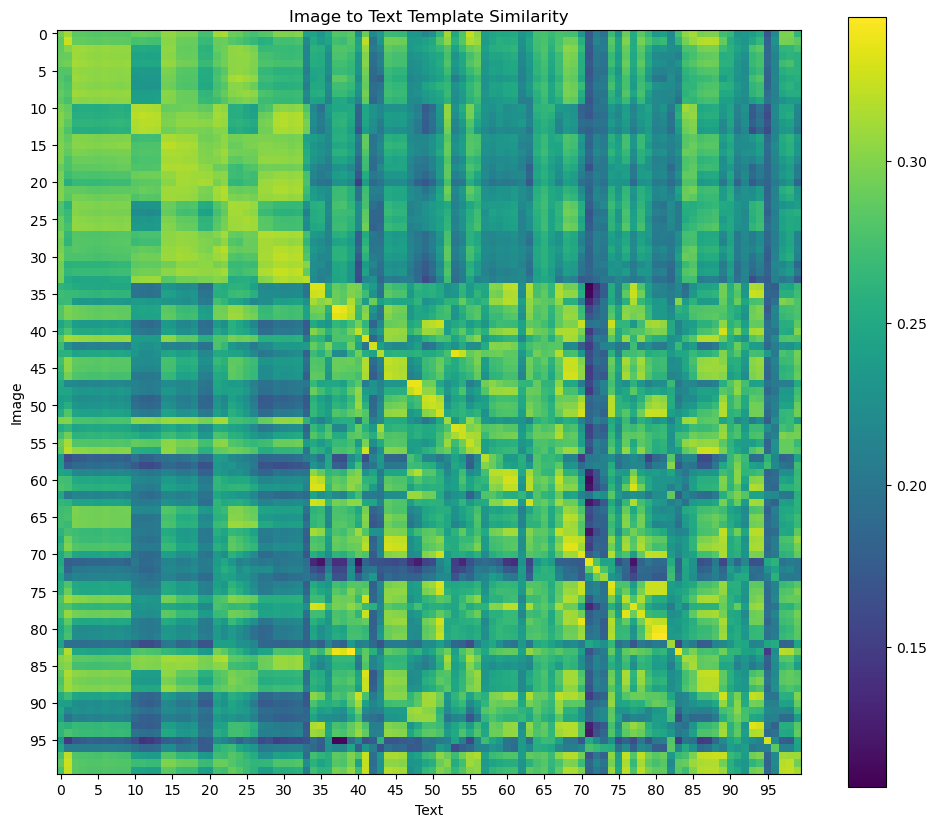

Image to text template similarity (individual) mean: 0.22727832198143005
Image to text template similarity (individual) std: 0.03500032797455788
Image to text template similarity (individual) diagonal mean: 0.2852539122104645
Image to text template similarity (individual) diagonal std: 0.01666097342967987
Image to text template similarity (individual) non-diagonal mean: 0.22669270634651184
Image to text template similarity (individual) non-diagonal std: 0.03464533016085625
Image to text template similarity (individual) diagonal mean to non-diagonal mean ratio: 1.2583285570144653
Rank 1: (83)Il-76 - (39)BAE-125, Similarity: 0.3115234375
Rank 2: (81)Gulfstream V - (81)Gulfstream V, Similarity: 0.311279296875
Rank 3: (47)Cessna 172 - (47)Cessna 172, Similarity: 0.308837890625
Rank 4: (37)BAE 146-200 - (37)BAE 146-200, Similarity: 0.307373046875
Rank 5: (81)Gulfstream V - (80)Gulfstream IV, Similarity: 0.30712890625
Rank 6: (80)Gulfstream IV - (81)Gulfstream V, Similarity: 0.30712890625
Ra

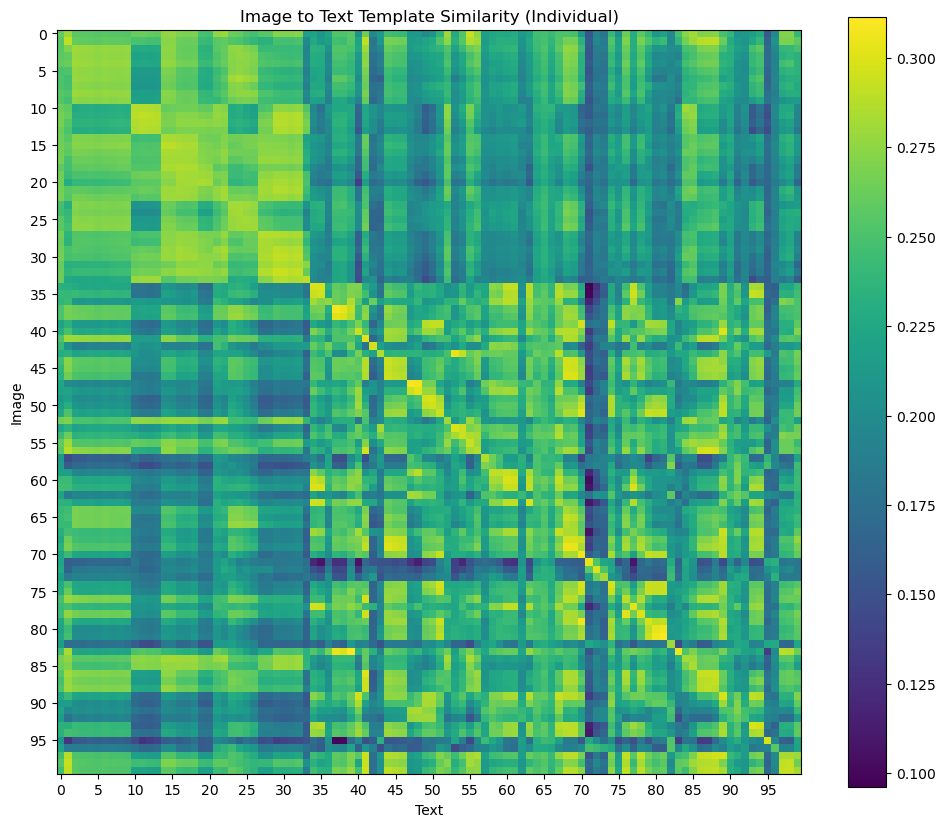

Image to original gpt-3 text similarity mean: 0.2430419921875
Image to original gpt-3 text similarity std: 0.0413818359375
Image to original gpt-3 text similarity diagonal mean: 0.314208984375
Image to original gpt-3 text similarity diagonal std: 0.00914764404296875
Image to original gpt-3 text similarity non-diagonal mean: 0.242431640625
Image to original gpt-3 text similarity non-diagonal std: 0.04095458984375
Image to original gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.2958984375
Rank 1: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.333740234375
Rank 2: (59)DHC-6 - (59)DHC-6, Similarity: 0.33251953125
Rank 3: (69)ERJ 145 - (68)ERJ 135, Similarity: 0.331787109375
Rank 4: (68)ERJ 135 - (44)CRJ-200, Similarity: 0.33154296875
Rank 5: (69)ERJ 145 - (69)ERJ 145, Similarity: 0.331298828125
Rank 6: (34)ATR-42 - (34)ATR-42, Similarity: 0.331298828125
Rank 7: (68)ERJ 135 - (68)ERJ 135, Similarity: 0.329833984375
Rank 8: (68)ERJ 135 - (69)ERJ 145, Simi

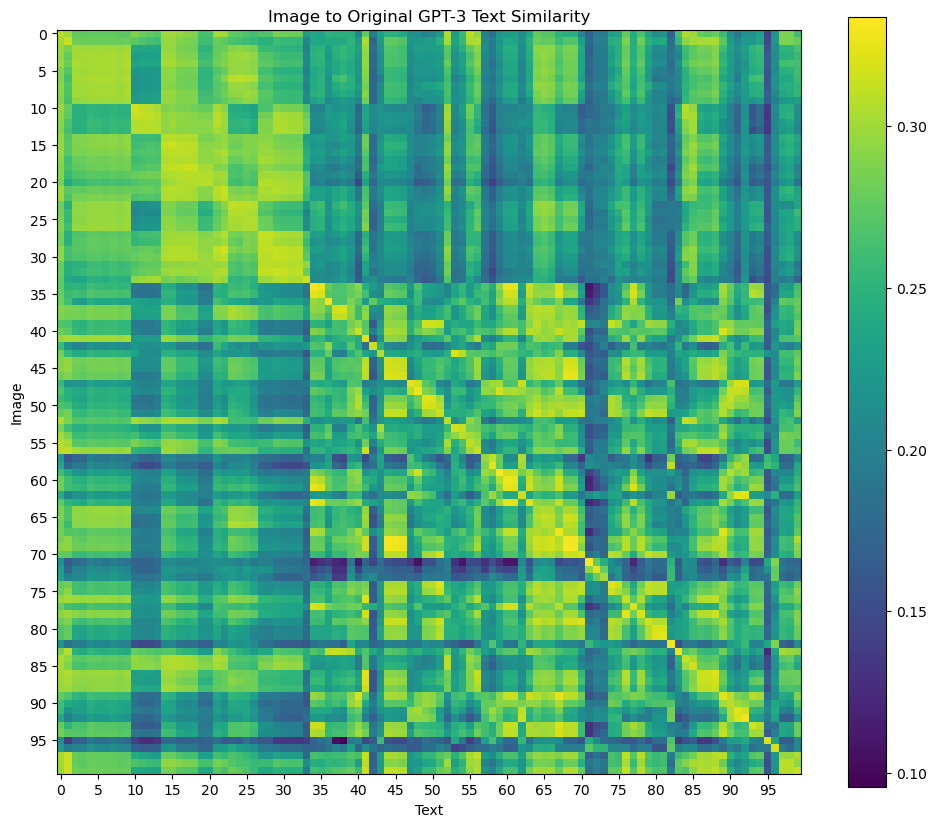

Image to original gpt-3 text similarity (individual) mean: 0.2366713136434555
Image to original gpt-3 text similarity (individual) std: 0.040498677641153336
Image to original gpt-3 text similarity (individual) diagonal mean: 0.3060034215450287
Image to original gpt-3 text similarity (individual) diagonal std: 0.010845774784684181
Image to original gpt-3 text similarity (individual) non-diagonal mean: 0.23597098886966705
Image to original gpt-3 text similarity (individual) non-diagonal std: 0.04008087143301964
Image to original gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.2967840433120728
Rank 1: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.327392578125
Rank 2: (69)ERJ 145 - (68)ERJ 135, Similarity: 0.3251953125
Rank 3: (69)ERJ 145 - (69)ERJ 145, Similarity: 0.32470703125
Rank 4: (34)ATR-42 - (34)ATR-42, Similarity: 0.323486328125
Rank 5: (68)ERJ 135 - (69)ERJ 145, Similarity: 0.3232421875
Rank 6: (68)ERJ 135 - (68)ERJ 135, Similarit

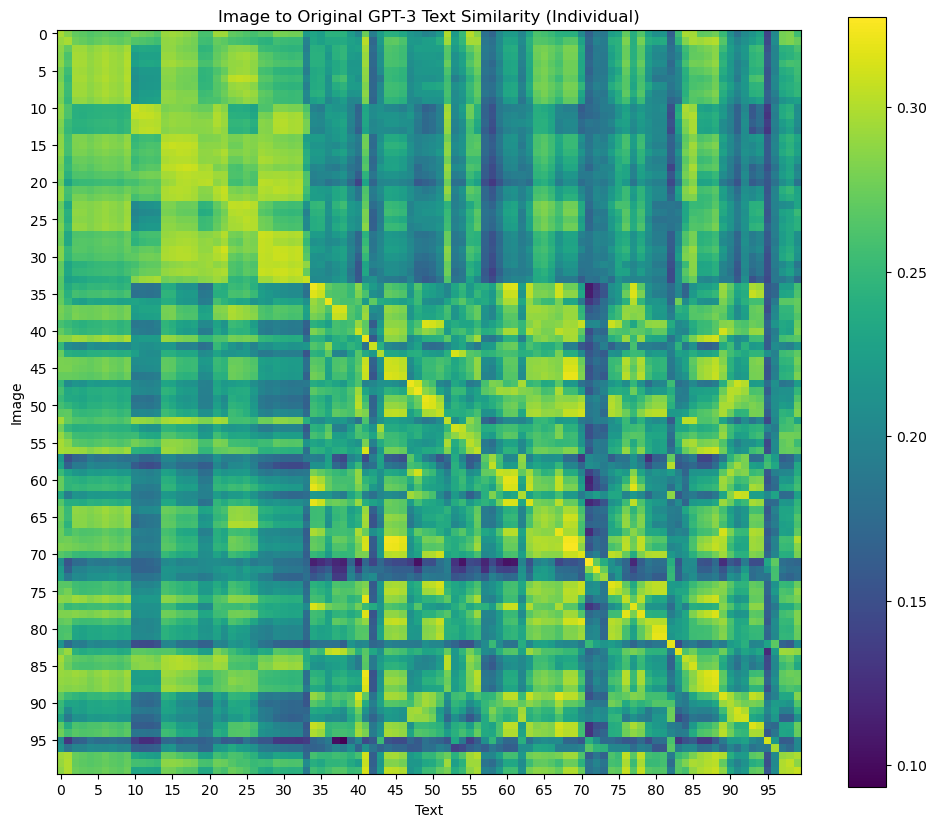

Image to filtered gpt-3 text similarity mean: 0.2423095703125
Image to filtered gpt-3 text similarity std: 0.0418701171875
Image to filtered gpt-3 text similarity diagonal mean: 0.314697265625
Image to filtered gpt-3 text similarity diagonal std: 0.0091400146484375
Image to filtered gpt-3 text similarity non-diagonal mean: 0.2415771484375
Image to filtered gpt-3 text similarity non-diagonal std: 0.04144287109375
Image to filtered gpt-3 text similarity diagonal mean to non-diagonal mean ratio: 1.302734375
Rank 1: (57)DH-82 - (57)DH-82, Similarity: 0.33740234375
Rank 2: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.333740234375
Rank 3: (69)ERJ 145 - (68)ERJ 135, Similarity: 0.331787109375
Rank 4: (68)ERJ 135 - (44)CRJ-200, Similarity: 0.33154296875
Rank 5: (59)DHC-6 - (59)DHC-6, Similarity: 0.33154296875
Rank 6: (34)ATR-42 - (34)ATR-42, Similarity: 0.331298828125
Rank 7: (69)ERJ 145 - (69)ERJ 145, Similarity: 0.331298828125
Rank 8: (68)ERJ 135 - (68)ERJ 135, Similarity

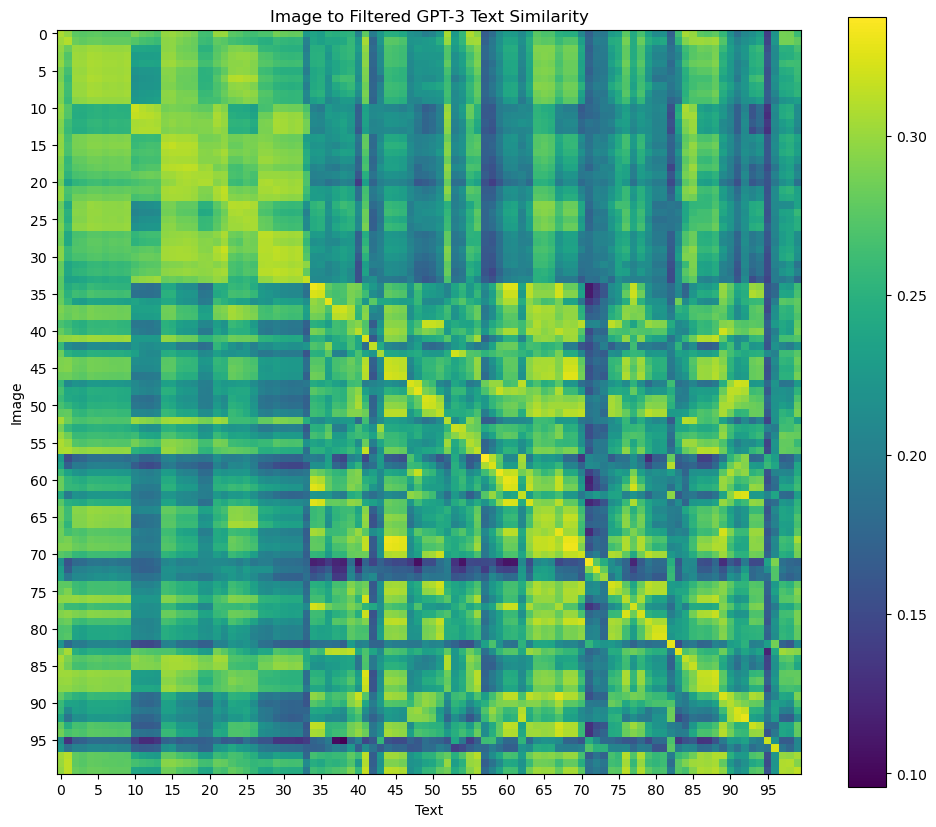

Image to filtered gpt-3 text similarity (individual) mean: 0.23692196607589722
Image to filtered gpt-3 text similarity (individual) std: 0.04107410088181496
Image to filtered gpt-3 text similarity (individual) diagonal mean: 0.30759522318840027
Image to filtered gpt-3 text similarity (individual) diagonal std: 0.009119695983827114
Image to filtered gpt-3 text similarity (individual) non-diagonal mean: 0.23620809614658356
Image to filtered gpt-3 text similarity (individual) non-diagonal std: 0.04064876213669777
Image to filtered gpt-3 text similarity (individual) diagonal mean to non-diagonal mean ratio: 1.3022212982177734
Rank 1: (71)Eurofighter Typhoon - (71)Eurofighter Typhoon, Similarity: 0.327392578125
Rank 2: (69)ERJ 145 - (68)ERJ 135, Similarity: 0.3251953125
Rank 3: (69)ERJ 145 - (69)ERJ 145, Similarity: 0.32470703125
Rank 4: (34)ATR-42 - (34)ATR-42, Similarity: 0.323486328125
Rank 5: (68)ERJ 135 - (69)ERJ 145, Similarity: 0.3232421875
Rank 6: (68)ERJ 135 - (68)ERJ 135, Similari

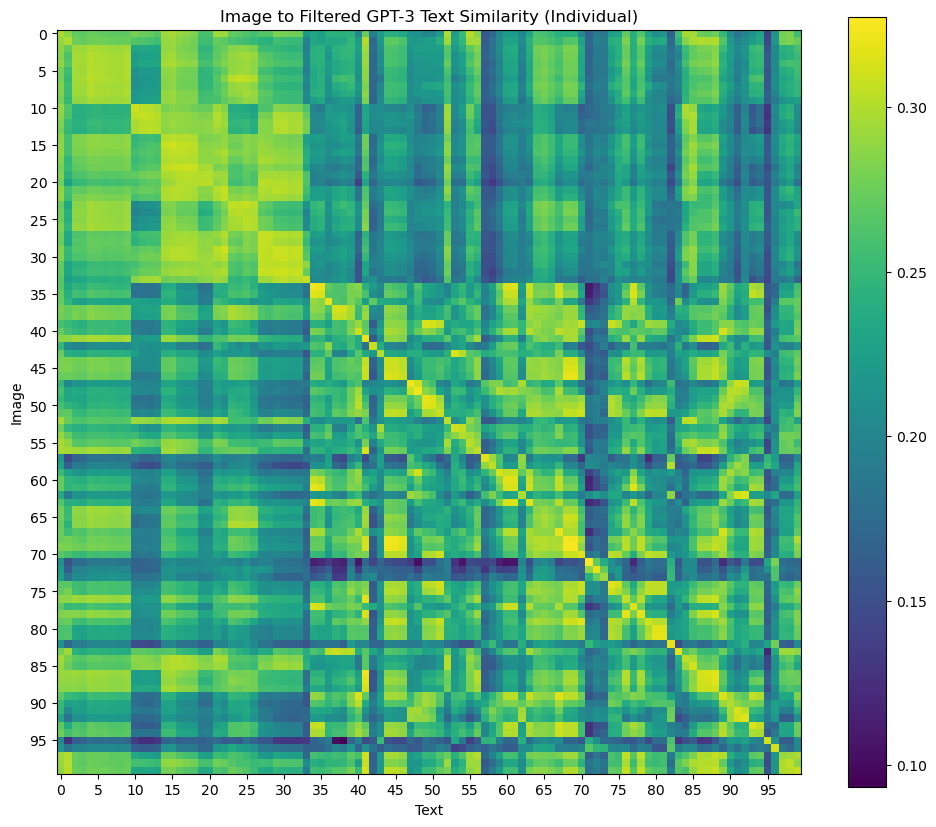

In [24]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image Similarity')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, 'Image to Class Name Similarity')
visualize_cross_similarity(img_template_cls_similarity, 'Image to Text Template Similarity')
visualize_cross_similarity(img_template_text_similarity, 'Image to Text Template Similarity (Individual)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, 'Image to Original GPT-3 Text Similarity')
visualize_cross_similarity(img_original_gpt3_text_similarity, 'Image to Original GPT-3 Text Similarity (Individual)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, 'Image to Filtered GPT-3 Text Similarity')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, 'Image to Filtered GPT-3 Text Similarity (Individual)')

In [25]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [26]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [27]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.9990234375
Rank 2: (6)737-600 - (7)737-700, Similarity: 0.99560546875
Rank 3: (4)737-400 - (6)737-600, Similarity: 0.9951171875
Rank 4: (5)737-500 - (6)737-600, Similarity: 0.99462890625
Rank 5: (6)737-600 - (8)737-800, Similarity: 0.99462890625
Rank 6: (7)737-700 - (8)737-800, Similarity: 0.994140625
Rank 7: (5)737-500 - (9)737-900, Similarity: 0.994140625
Rank 8: (4)737-400 - (5)737-500, Similarity: 0.994140625
Rank 9: (27)A330-200 - (28)A330-300, Similarity: 0.99365234375
Rank 10: (3)737-300 - (5)737-500, Similarity: 0.99365234375


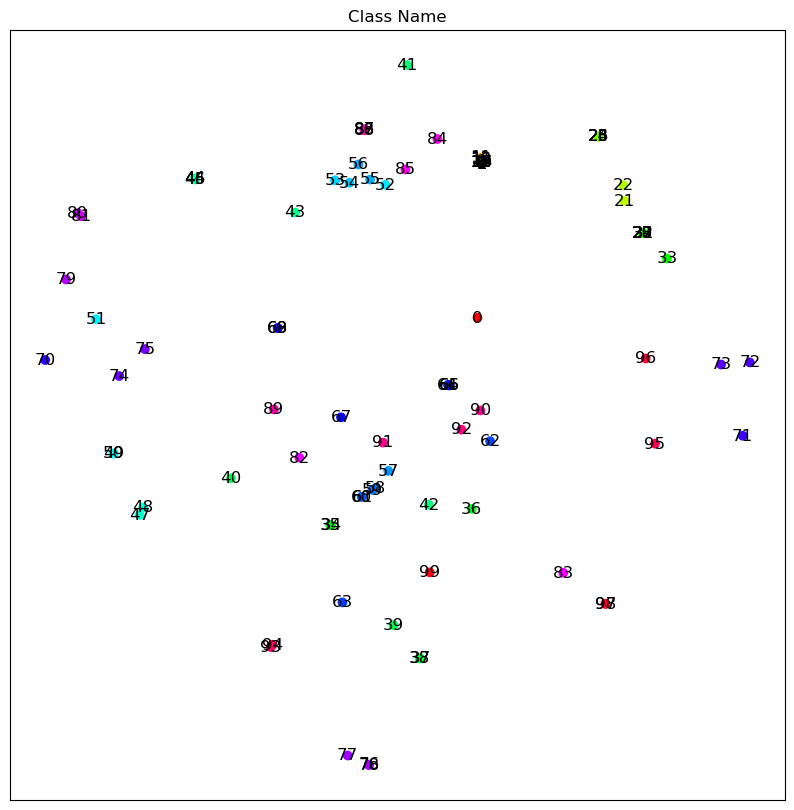

Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, Similarity: 0.998046875
Rank 3: (6)737-600 - (7)737-700, Similarity: 0.99755859375
Rank 4: (19)777-200 - (20)777-300, Similarity: 0.99755859375
Rank 5: (8)737-800 - (9)737-900, Similarity: 0.99755859375
Rank 6: (7)737-700 - (9)737-900, Similarity: 0.9970703125
Rank 7: (6)737-600 - (8)737-800, Similarity: 0.9970703125
Rank 8: (16)767-200 - (17)767-300, Similarity: 0.9970703125
Rank 9: (6)737-600 - (9)737-900, Similarity: 0.9970703125
Rank 10: (27)A330-200 - (28)A330-300, Similarity: 0.9970703125


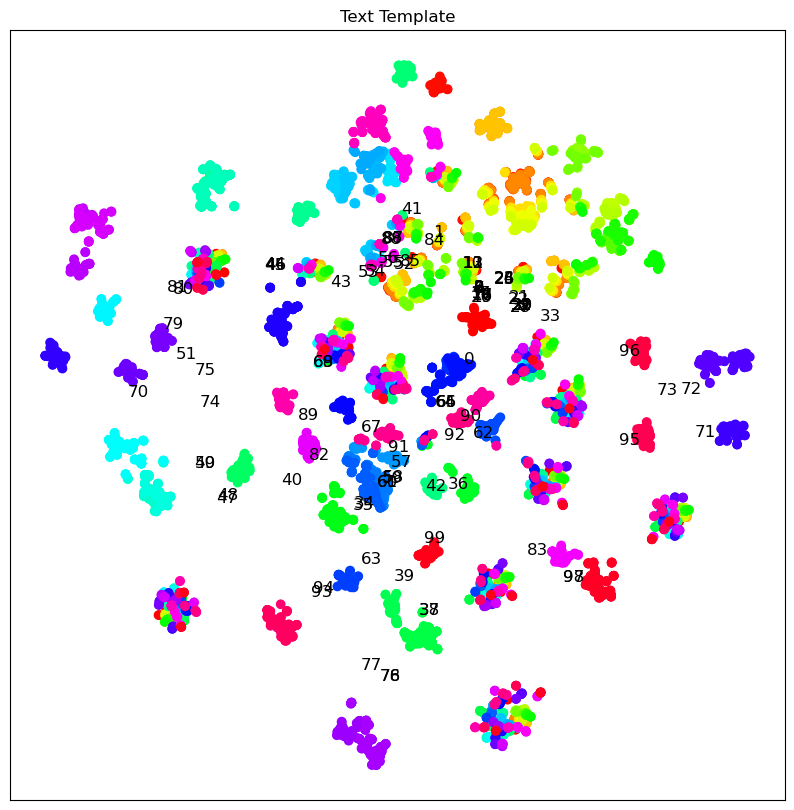

Rank 1: (31)A340-500 - (32)A340-600, Similarity: 0.99853515625
Rank 2: (6)737-600 - (9)737-900, Similarity: 0.998046875
Rank 3: (5)737-500 - (6)737-600, Similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, Similarity: 0.998046875
Rank 5: (17)767-300 - (18)767-400, Similarity: 0.998046875
Rank 6: (30)A340-300 - (32)A340-600, Similarity: 0.99755859375
Rank 7: (30)A340-300 - (31)A340-500, Similarity: 0.9970703125
Rank 8: (29)A340-200 - (30)A340-300, Similarity: 0.9970703125
Rank 9: (5)737-500 - (9)737-900, Similarity: 0.9970703125
Rank 10: (6)737-600 - (7)737-700, Similarity: 0.99658203125


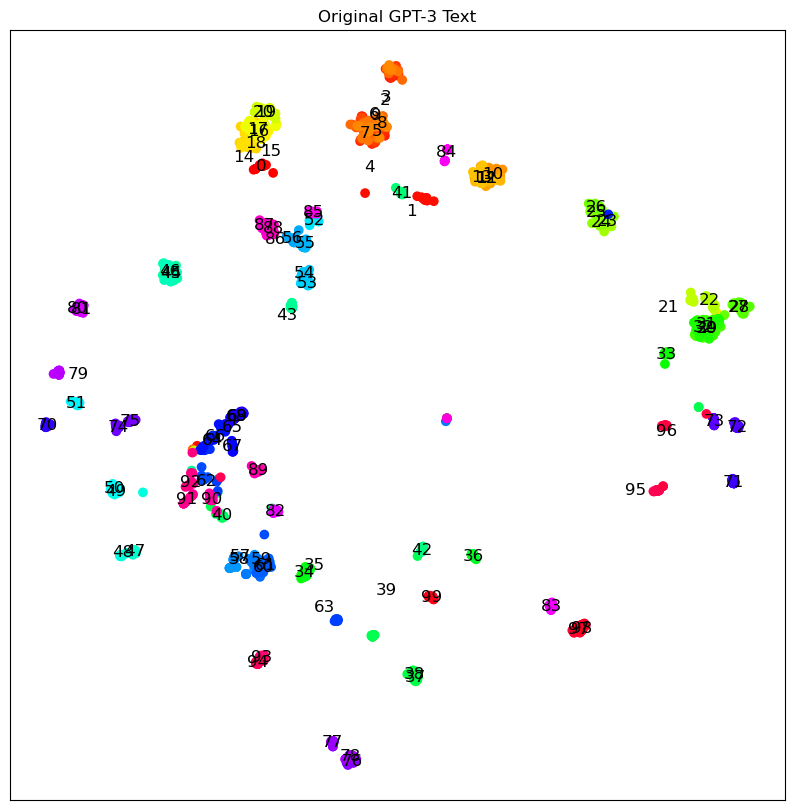

Rank 1: (5)737-500 - (6)737-600, Similarity: 0.99853515625
Rank 2: (31)A340-500 - (32)A340-600, Similarity: 0.99853515625
Rank 3: (6)737-600 - (9)737-900, Similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, Similarity: 0.998046875
Rank 5: (5)737-500 - (9)737-900, Similarity: 0.99755859375
Rank 6: (17)767-300 - (18)767-400, Similarity: 0.99755859375
Rank 7: (30)A340-300 - (32)A340-600, Similarity: 0.99755859375
Rank 8: (4)737-400 - (5)737-500, Similarity: 0.99755859375
Rank 9: (6)737-600 - (8)737-800, Similarity: 0.99755859375
Rank 10: (7)737-700 - (9)737-900, Similarity: 0.99755859375


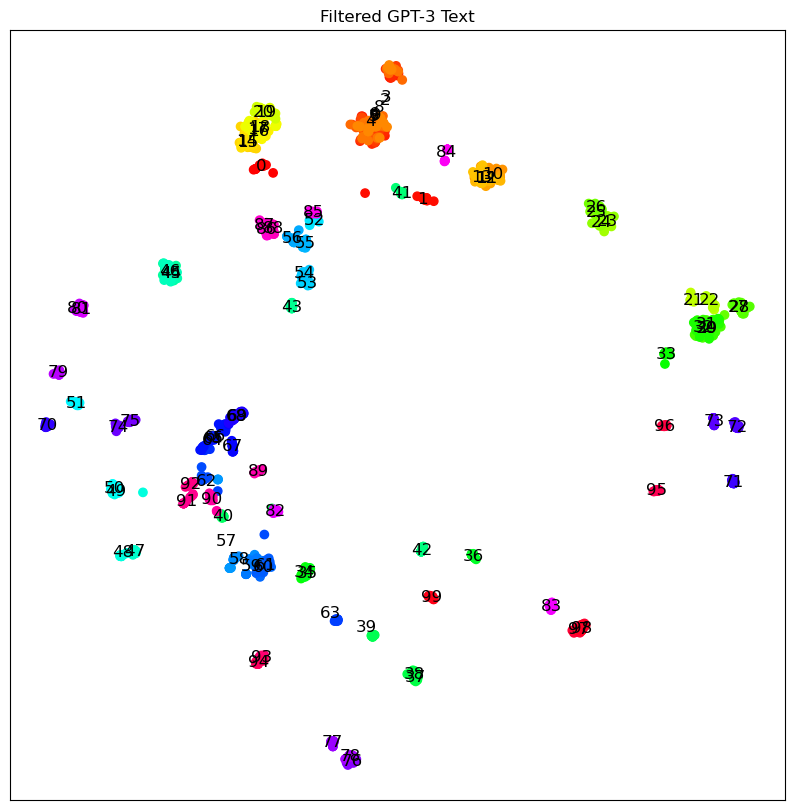

In [28]:
print_top_similarity(np.triu(cls_name_masked_similarity, k=1))
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_similarity(np.triu(template_masked_similarity, k=1))
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_similarity(np.triu(original_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_similarity(np.triu(filtered_gpt3_masked_similarity, k=1))
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')